In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
from IPython.display import clear_output
from time import sleep
import matplotlib.pyplot as plt


#Hyperparameters
learning_rate  = 0.0003
gamma           = 0.9
lmbda           = 0.9
eps_clip        = 0.2
K_epoch         = 10
rollout_len    = 3
buffer_size    = 30
minibatch_size = 32

class PPO(nn.Module):
    def __init__(self):
        super(PPO, self).__init__()
        self.data = []
        
        self.fc1   = nn.Linear(3,128)
        self.fc_mu = nn.Linear(128,1)
        self.fc_std  = nn.Linear(128,1)
        self.fc_v = nn.Linear(128,1)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.optimization_step = 0

    def pi(self, x, softmax_dim = 0):
        x = F.relu(self.fc1(x))
        mu = 2.0*torch.tanh(self.fc_mu(x))
        std = F.softplus(self.fc_std(x))
        return mu, std
    
    def v(self, x):
        x = F.relu(self.fc1(x))
        v = self.fc_v(x)
        return v
      
    def put_data(self, transition):
        self.data.append(transition)
        
    def make_batch(self):
        s_batch, a_batch, r_batch, s_prime_batch, prob_a_batch, done_batch = [], [], [], [], [], []
        data = []

        for j in range(buffer_size):
            for i in range(minibatch_size):
                rollout = self.data.pop()
                s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []

                for transition in rollout:
                    s, a, r, s_prime, prob_a, done = transition
                    
                    s_lst.append(s)
                    a_lst.append([a])
                    r_lst.append([r])
                    s_prime_lst.append(s_prime)
                    prob_a_lst.append([prob_a])
                    done_mask = 0 if done else 1
                    done_lst.append([done_mask])

                s_batch.append(s_lst)
                a_batch.append(a_lst)
                r_batch.append(r_lst)
                s_prime_batch.append(s_prime_lst)
                prob_a_batch.append(prob_a_lst)
                done_batch.append(done_lst)
                    
            mini_batch = torch.tensor(s_batch, dtype=torch.float), torch.tensor(a_batch, dtype=torch.float), \
                          torch.tensor(r_batch, dtype=torch.float), torch.tensor(s_prime_batch, dtype=torch.float), \
                          torch.tensor(done_batch, dtype=torch.float), torch.tensor(prob_a_batch, dtype=torch.float)
            data.append(mini_batch)

        return data

    def calc_advantage(self, data):
        data_with_adv = []
        for mini_batch in data:
            s, a, r, s_prime, done_mask, old_log_prob = mini_batch
            with torch.no_grad():
                td_target = r + gamma * self.v(s_prime) * done_mask
                delta = td_target - self.v(s)
            delta = delta.numpy()

            advantage_lst = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype=torch.float)
            data_with_adv.append((s, a, r, s_prime, done_mask, old_log_prob, td_target, advantage))

        return data_with_adv

        
    def train_net(self):
        if len(self.data) == minibatch_size * buffer_size:
            data = self.make_batch()
            data = self.calc_advantage(data)

            for i in range(K_epoch):
                for mini_batch in data:
                    s, a, r, s_prime, done_mask, old_log_prob, td_target, advantage = mini_batch

                    mu, std = self.pi(s, softmax_dim=1)
                    dist = Normal(mu, std)
                    log_prob = dist.log_prob(a)
                    ratio = torch.exp(log_prob - old_log_prob)  # a/b == exp(log(a)-log(b))

                    surr1 = ratio * advantage
                    surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantage
                    loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(self.v(s) , td_target)

                    self.optimizer.zero_grad()
                    loss.mean().backward()
                    nn.utils.clip_grad_norm_(self.parameters(), 1.0)
                    self.optimizer.step()
                    self.optimization_step += 1
        
env = gym.make('Pendulum-v0')
model = PPO()
score = 0.0
scores = []
print_interval = 20
rollout = []

for n_epi in range(10000):
    s = env.reset()
    done = False
    while not done:
        for t in range(rollout_len):
            mu, std = model.pi(torch.from_numpy(s).float())
            dist = Normal(mu, std)
            a = dist.sample()
            log_prob = dist.log_prob(a)
            s_prime, r, done, info = env.step([a.item()])

            rollout.append((s, a, r/10.0, s_prime, log_prob.item(), done))
            if len(rollout) == rollout_len:
                model.put_data(rollout)
                rollout = []

            s = s_prime
            score += r
            if done:
                break

        model.train_net()

    if n_epi%print_interval==0 and n_epi!=0:
        clear_output(wait=True)
        print("# of episode :{}, avg score : {:.1f}, opt step: {}".format(n_epi, score/print_interval, model.optimization_step))
        scores.append(score)
        score = 0.0

env.close()


# of episode :9980, avg score : -166.6, opt step: 207900


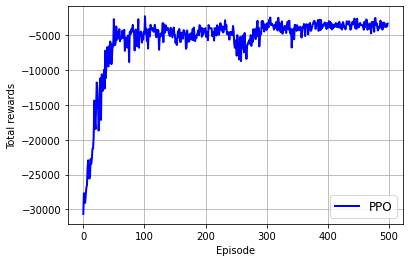

In [2]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(range(len(scores)), np.array(scores), 'b', linewidth = 2, label = 'PPO')
plt.legend(prop={'size':12})
plt.xlabel('Episode')
plt.ylabel('Total rewards')
#plt.xlim(0, no_of_episodes)
#plt.ylim(0, 20000)
#plt.legend(['Double DQN', 'Dueling DQN', 'D3QN'], loc=4)
plt.grid(True)

In [4]:
# Test
from time import sleep

for n_epi in range(2):
    s = env.reset()
    done = False
        
    while not done:
        mu, std = model.pi(torch.from_numpy(s).float())
        dist = Normal(mu, std)
        a = dist.sample()        
        s_prime, r, done, info = env.step([a])
        env.render()
        sleep(0.01)
        score +=r
        s = s_prime
                
        
    if n_epi%print_interval==0 and n_epi!=0:
        clear_output(wait=True)
        print("# of episode :{}, avg score : {:.1f}".format(n_epi, score/print_interval))
        score = 0.0

env.close()